In [1]:
import pdal
import pandas as pd
import json
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon, Point, mapping
import numpy as np
from pyproj import Proj, transform
import folium
import laspy as lp
import richdem as rd
import rasterio
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import sys
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
#loading and reading json file
def read_json(json_path):
    try:
        with open(json_path) as json_file:
            data = json.load(json_file)
            return data
    except FileNotFoundError:
        print("File not found")

A function to change to the needed CRS format for better visualization.
Convert lon/lat (in degrees) to x/y native map projection coordinates (in meters).


The most common global CRS(coordinate reference system) in latitude and longitude is WGS84
(used by the GPS satellite navigation system) with the following CRS string "+init=epsg:4326" as identifier. This is what we shall use here

In [3]:
def convert_EPSG(fromT, lon, lat):
    """parameters
    fromT: the original EPSG format
    lon: the longitude value
    lat: the latitude value
    """
    P4326 = Proj(init='epsg:4326')
    P3857 = Proj(init='epsg:3857')
    if fromT == 4326:
        input1 = P4326
        input2 = P3857
    else:
        input1 = p3857
        input2 = p4326

    x, y = transform(input1, input2, lon, lat)
    return [x, y]

In [4]:
#A function to change format of a list of coordinates to a list of points


def loop_EPSG_converter(listin):
    converted = []
    for item in listin:
        converted.append(convert_EPSG(4326, item[0], item[1]))

    return converted

In [5]:
def generate_polygon(coor, epsg):
    polygon_g = Polygon(coor)
    crs = {'init': 'epsg:'+str(epsg)}
    polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_g])       
    return polygon

In [6]:
#generating a dataframe given a CRS format and pipe
def generate_geo_df(pipe, epsg):
    try:
        cloud_points = []
        elevations =[]
        geometry_points=[]
        for row in pipe.arrays[0]:
            lst = row.tolist()[-3:]
            cloud_points.append(lst)
            elevations.append(lst[2])
            point = Point(lst[0], lst[1])
            geometry_points.append(point)
        geodf = gpd.GeoDataFrame(columns=["elevation", "geometry"])
        geodf['elevation'] = elevations
        geodf['geometry'] = geometry_points
        geodf = geodf.set_geometry("geometry")
        geodf.set_crs(epsg = epsg, inplace=True)
        return geodf
    except RuntimeError as e:
        print(e)

In [7]:
# Coordinates for the polygon and generating the polygon from the given co-ordinate

coordinates = [
    [-93.756055, 41.918115],
    [-93.756155, 41.918215],
    [-93.756396, 41.918475],
    [-93.755955, 41.918300],
    [-93.755795, 41.918000],
]

polygon = generate_polygon(coordinates, 4326)

In [8]:
# A function to display the polygon on a map
def show_on_map(polygon, zoom):
    #region selection
    poly = mapping((polygon.iloc[:,0][0]))
    tmp = poly['coordinates'][0][0]
    anchor = [tmp[1], tmp[0]]
    map = folium.Map(anchor,zoom_start=zoom, tiles='cartodbpositron')
    folium.GeoJson(polygon).add_to(map)
    folium.LatLngPopup().add_to(map)
    return map

show_on_map(polygon, 20)

In [9]:
# Changing the co-ordinates of the polygon to the standard EPSG CRS format and generating a polgon

coor = loop_EPSG_converter(coordinates)
print(coor)
polygon_standard = generate_polygon(coor, 4326)

[[-10436876.301386151, 5148721.349314567], [-10436887.43333523, 5148736.309605352], [-10436914.26133251, 5148775.206471106], [-10436865.169437071, 5148749.025870951], [-10436847.358318545, 5148704.145009145]]


In [10]:
# Modifying the already created json file to fetch the data


def modify_pipe_json(json_loc, url, region, in_epsg, out_epsg):
    dicti = read_json(json_loc)
    dicti['pipeline'][0]['polygon'] = str(polygon_standard.iloc[:, 0][0])
    dicti['pipeline'][0]['filename'] = f"{url}/{region}/ept.json"
    dicti['pipeline'][2]['in_srs'] = f"EPSG:{in_epsg}"
    dicti['pipeline'][2]['out_srs'] = f"EPSG:{out_epsg}"
    print(dicti)
    return dicti


location = "../pipe.json"
url = "https://s3-us-west-2.amazonaws.com/usgs-lidar-public"
region = "IA_FullState"
in_srs = 3857
out_srs = 4326

request = modify_pipe_json(location, url, region, in_srs, out_srs)

{'pipeline': [{'polygon': 'POLYGON ((-10436876.301386151 5148721.349314567, -10436887.43333523 5148736.309605352, -10436914.26133251 5148775.206471106, -10436865.169437071 5148749.025870951, -10436847.358318545 5148704.145009145, -10436876.301386151 5148721.349314567))', 'filename': 'https://s3-us-west-2.amazonaws.com/usgs-lidar-public/IA_FullState/ept.json', 'type': 'readers.ept', 'tag': 'readdata'}, {'type': 'filters.range', 'limits': 'Classification![7:7]', 'tag': 'no_noise'}, {'in_srs': 'EPSG:3857', 'out_srs': 'EPSG:4326', 'tag': 'reprojectUTM', 'type': 'filters.reprojection'}, {'filename': 'iowa.csv', 'tag': 'writerscsv', 'type': 'writers.text'}, {'filename': 'iowa.las', 'tag': 'writersply', 'type': 'writers.las'}]}


In [11]:
# Creatng the pipe
pipe = pdal.Pipeline(json.dumps(request))

In [12]:
pipe.execute()

1371

In [13]:
# Generating the dataframe from the pipeline
df = generate_geo_df(pipe, 4326)

In [14]:
df.head()

,elevation,geometry
0,310.37,POINT (-93.75581 41.91802)
1,310.56,POINT (-93.75582 41.91803)
2,310.33,POINT (-93.75585 41.91803)
3,310.42,POINT (-93.75587 41.91804)
4,310.30,POINT (-93.75584 41.91804)


In [35]:
def plot_2d_heatmap(df,column,title):
    """
    plot a 2d heat map of the terrain
    args:
        df (geopndas df): a geopandas dataframe demonstrating the data
        column (str): input column to outline in string
        title (str): input title of the map in string
    return:
        2d heat map of terrain
    """
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    fig.patch.set_alpha(0)
    plt.grid('on', zorder=0)
    df.plot(column=column, ax=ax, legend=True, cmap="terrain")
    plt.title(title) 
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

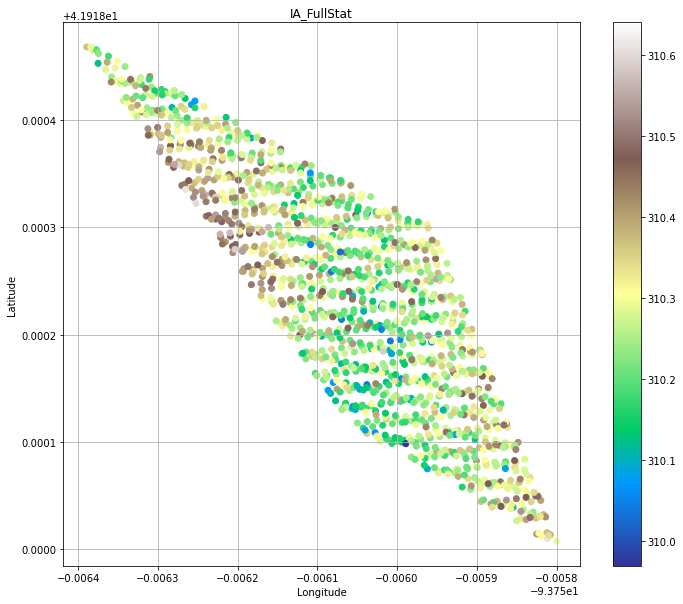

In [36]:
plot_2d_heatmap(df,column='elevation',title="IA_FullStat")

In [16]:
import laspy

In [17]:
las=laspy.read('iowa.las')

In [18]:
las.header

<LasHeader(1.2, <PointFormat(3, 0 bytes of extra dims)>)>

In [19]:
las.header.point_format

<PointFormat(3, 0 bytes of extra dims)>

In [20]:
las.header.point_count

1371

In [21]:
las.vlrs

[<GeoKeyDirectoryVlr(7 geo_keys)>, <GeoDoubleParamsVlr([c_double(298.257223563), c_double(6378137.0)])>, <GeoAsciiParamsVlr(['WGS 84|', ''])>]

In [22]:
list(las.point_format.dimension_names)

['X',
 'Y',
 'Z',
 'intensity',
 'return_number',
 'number_of_returns',
 'scan_direction_flag',
 'edge_of_flight_line',
 'classification',
 'synthetic',
 'key_point',
 'withheld',
 'scan_angle_rank',
 'user_data',
 'point_source_id',
 'gps_time',
 'red',
 'green',
 'blue']

In [23]:
las.X

array([-9376, -9376, -9376, ..., -9376, -9376, -9376])

In [24]:
las.intensity

array([ 2,  4,  2, ...,  5, 45, 49], dtype=uint16)

In [25]:
las.gps_time

array([51758.230952, 51758.263222, 51758.26325 , ..., 53290.488925,
       53290.580823, 51758.708794])

### Lidar Classification
Every lidar point can have a classification assigned to it that defines the type of object that has reflected the laser pulse. Lidar points can be classified into a number of categories including bare earth or ground, top of canopy, and water. The different classes are defined using numeric integer codes in the LAS files.

Now let's check the classification of our lidar data

In [26]:
set(list(las.classification))

{1, 2, 12}

In [27]:
point_data = np.stack([las.X, las.Y, las.Z], axis=0).transpose((1, 0))
point_data

array([[-9376,  4192, 31037],
       [-9376,  4192, 31056],
       [-9376,  4192, 31033],
       ...,
       [-9376,  4192, 31019],
       [-9376,  4192, 31034],
       [-9376,  4192, 31026]])

In [28]:
points_pass = laspy.create(point_format=las.header.point_format, file_version=las.header.version)
points_pass.points = las.points[las.classification == 1]

In [30]:
from mpl_toolkits import mplot3d

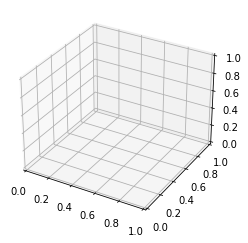

In [31]:
ax = plt.axes(projection='3d')